In [4]:
import tensorflow as tf
from qkeras import *

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    lq.layers.QConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("binary_tanh")
])

ValueError: One of the dimensions in the output is <= 0 due to downsampling in first_conv2d. Consider increasing the input size. Received input shape [None, 1, 28, 28] which would produce output shape with a zero or negative value in a dimension.

ModuleNotFoundError: No module named 'binary_ops'

In [3]:
train = True

if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
#     callbacks = all_callbacks(stop_patience = 1000,
#                               lr_factor = 0.5,
#                               lr_patience = 10,
#                               lr_epsilon = 0.000001,
#                               lr_cooldown = 2,
#                               lr_minimum = 0.0000001,
#                               outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024, epochs=30, validation_split=0.25, shuffle=True)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
487/487 [==============================] - 2s 1ms/step - loss: 1.2812 - accuracy: 0.5356 - val_loss: 1.0623 - val_accuracy: 0.6327
Epoch 2/30
487/487 [==============================] - 1s 1ms/step - loss: 1.0285 - accuracy: 0.6383 - val_loss: 1.0107 - val_accuracy: 0.6539
Epoch 3/30
487/487 [==============================] - 1s 1ms/step - loss: 0.9946 - accuracy: 0.6581 - val_loss: 1.0029 - val_accuracy: 0.6553
Epoch 4/30
487/487 [==============================] - 1s 1ms/step - loss: 0.9680 - accuracy: 0.6716 - val_loss: 0.9525 - val_accuracy: 0.6845
Epoch 5/30
487/487 [==============================] - 1s 1ms/step - loss: 0.9416 - accuracy: 0.6825 - val_loss: 0.9388 - val_accuracy: 0.6861
Epoch 6/30
487/487 [==============================] - 1s 1ms/step - loss: 0.9184 - accuracy: 0.6928 - val_loss: 0.9405 - val_accuracy: 0.6772
Epoch 7/30
487/487 [==============================] - 1s 1ms/step - loss: 0.8993 - accuracy: 0.7000 - val_loss: 0.9016 - val_accuracy: 0.7031
Epoch 

In [4]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
# plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xc7a100t_ftg256.bsd')

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, 

/home/chmoser/miniconda3/envs/tf/lib/python3.9/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [5]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


5188/5188 [==============================] - 2s 351us/step
Accuracy: 0.7117349397590361
Keras  Accuracy: 0.7117349397590361
hls4ml Accuracy: 0.20940361445783132


<Figure size 900x900 with 0 Axes>

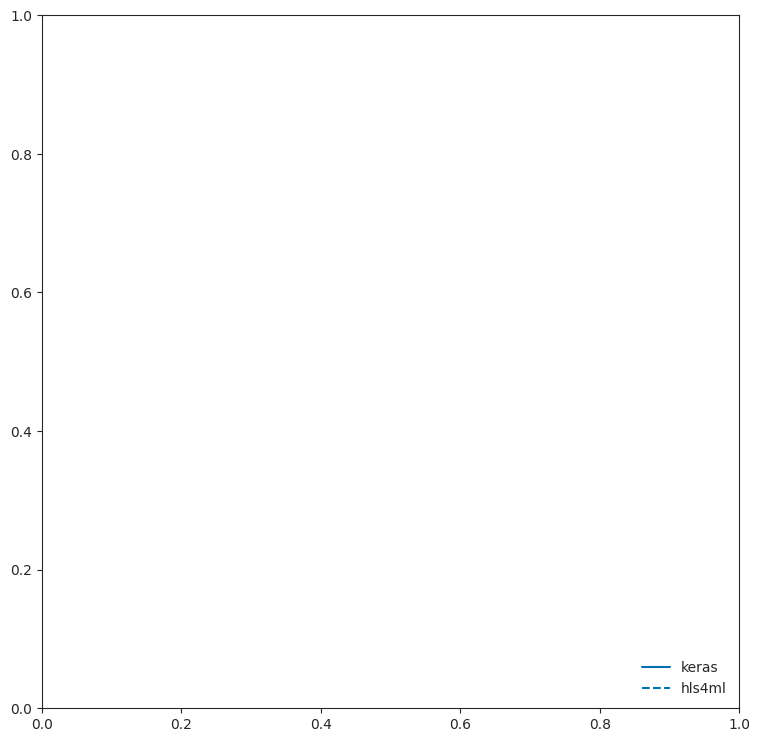

In [6]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
# _ = plotting.makeRoc(y_test, y_keras, le.classes_)

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
# _ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None) # reset the colors
# _ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

In [7]:
hls_model.build(csim=False)

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.

In [8]:
hls_model.compile()

Writing HLS project
Done


OSError: libdl.so: cannot open shared object file: No such file or directory